In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [91]:
df = pd.read_csv('starts.csv')
df['event_date'] = pd.to_datetime(df['event_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178857 entries, 0 to 178856
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   record_id                  178857 non-null  int64         
 1   athlete_id                 178857 non-null  int64         
 2   event_name                 178857 non-null  object        
 3   event_date                 178857 non-null  datetime64[ns]
 4   city                       178857 non-null  object        
 5   region                     178857 non-null  object        
 6   finish_time                178857 non-null  int64         
 7   athlete_gender             178857 non-null  object        
 8   athlete_age                178857 non-null  int64         
 9   is_newbie                  178857 non-null  int64         
 10  temp                       178857 non-null  float64       
 11  feels_like                 178857 non-null  float64 

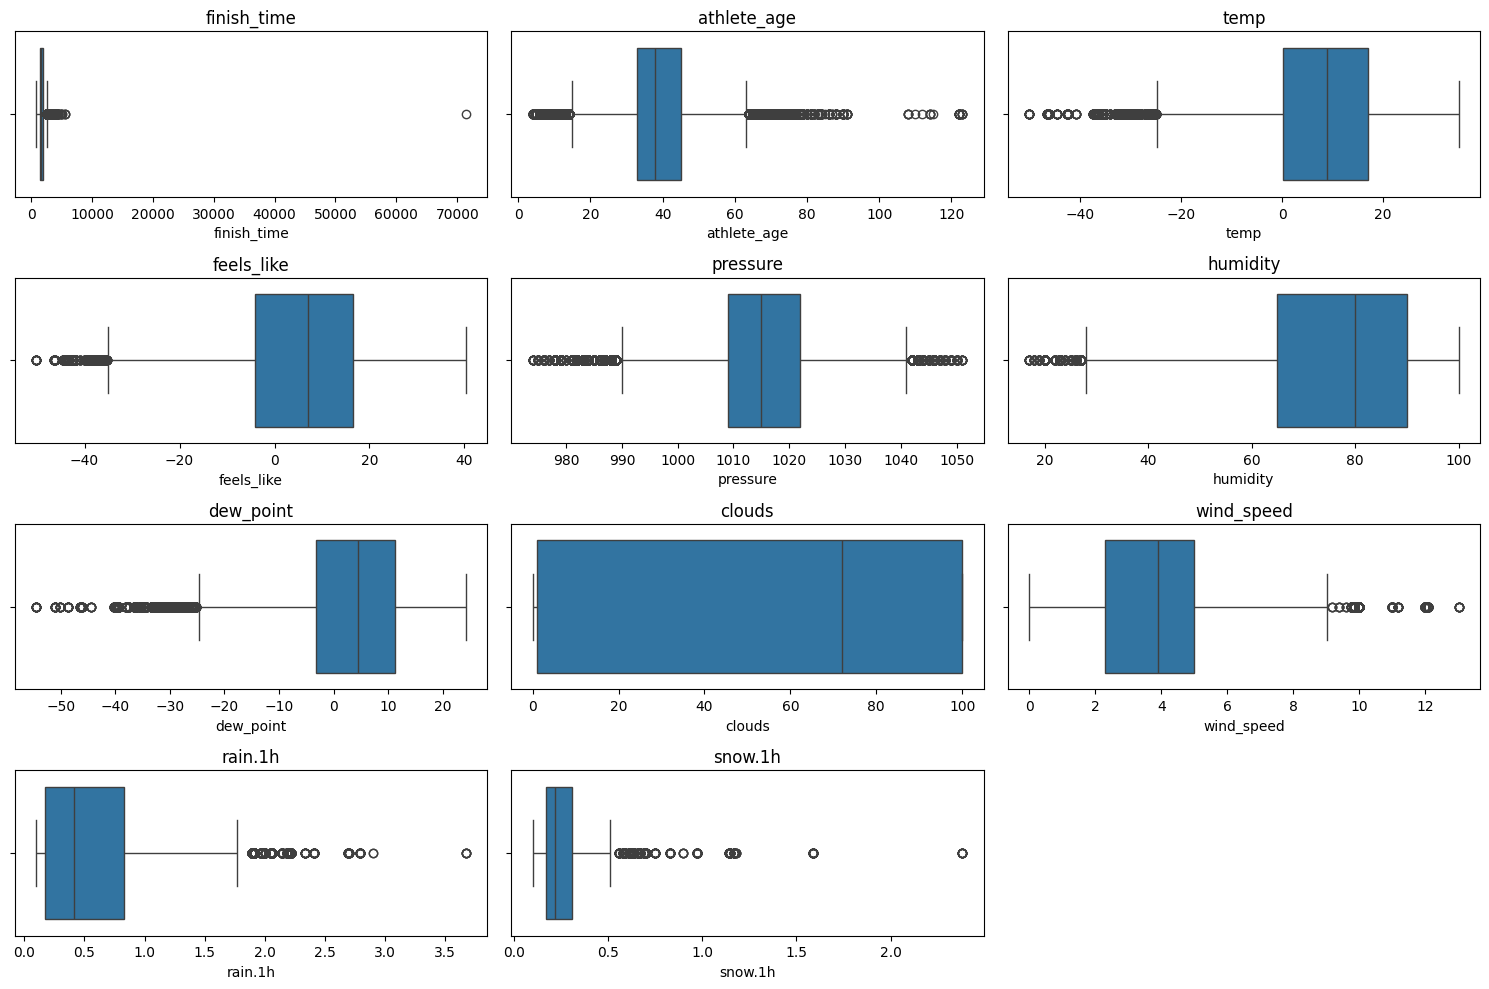

In [92]:
numerical_df = df[['finish_time', 'athlete_age', 'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'rain.1h', 'snow.1h', ]]
plt.figure(figsize=(15, 10))  
for i, column in enumerate(numerical_df.columns):  
    plt.subplot(len(numerical_df.columns) // 3 + 1, 3, i + 1)  
    sns.boxplot(x=numerical_df[column])  
    plt.title(column)  

plt.tight_layout()  
plt.show()  

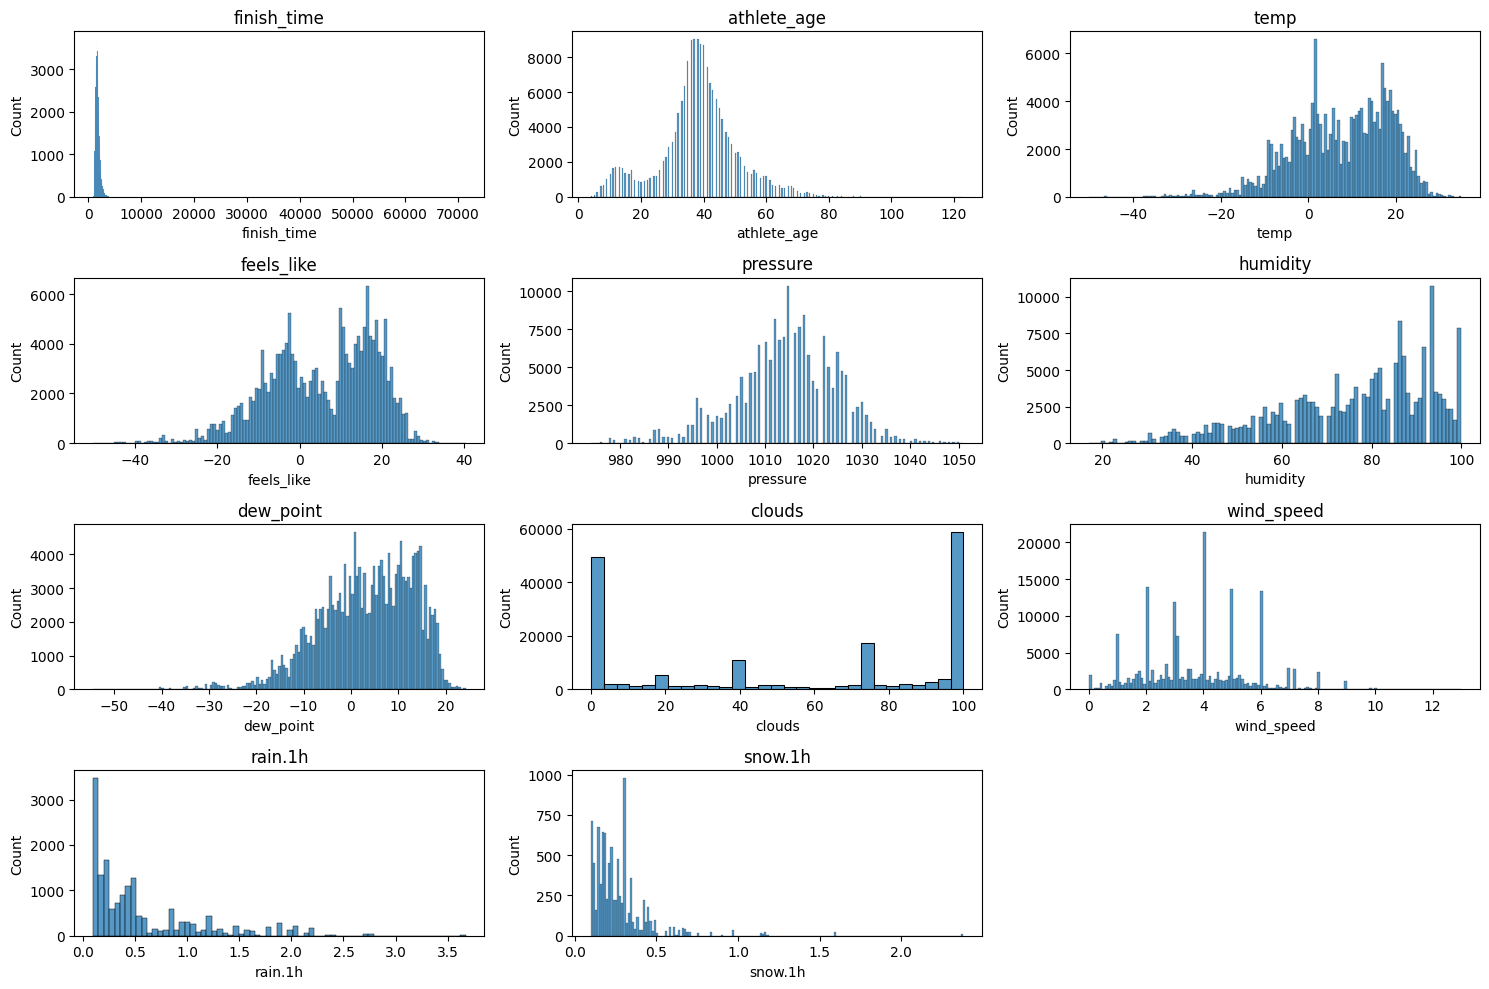

In [93]:
numerical_df = df[['finish_time', 'athlete_age', 'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'rain.1h', 'snow.1h', ]]
plt.figure(figsize=(15, 10))  
for i, column in enumerate(numerical_df.columns):  
    plt.subplot(len(numerical_df.columns) // 3 + 1, 3, i + 1)  
    sns.histplot(x=numerical_df[column])  
    plt.title(column)  

plt.tight_layout()  
plt.show()  

In [94]:
outliers = pd.DataFrame(columns=['Переменная', 'Нижняя граница', 'Верхняя граница', 'IQR', 'Количество выбросов'])
for column in numerical_df.columns:
    q1 = numerical_df[column].quantile(0.25)  # 25-й процентиль
    q3 = numerical_df[column].quantile(0.75)  # 75-й процентиль
    iqr = q3 - q1
    outliers = pd.concat([outliers, pd.DataFrame([{'Переменная': column, 'Нижняя граница': q1 - 1.5 * iqr, 'Верхняя граница': q3 + 1.5 * iqr, 'IQR': iqr, 'Количество выбросов': df[(df[column] > q3 + 1.5 * iqr) | (df[column] < q1 - 1.5 * iqr)].shape[0]}])], ignore_index=True)
outliers

/var/folders/nv/y1xwhy_x1gx4gn0wks7mdjqc0000gn/T/ipykernel_60979/3604549245.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers = pd.concat([outliers, pd.DataFrame([{'Переменная': column, 'Нижняя граница': q1 - 1.5 * iqr, 'Верхняя граница': q3 + 1.5 * iqr, 'IQR': iqr, 'Количество выбросов': df[(df[column] > q3 + 1.5 * iqr) | (df[column] < q1 - 1.5 * iqr)].shape[0]}])], ignore_index=True)


,Переменная,Нижняя граница,Верхняя граница,IQR,Количество выбросов
0,finish_time,741.500,2665.500,481.00,6484
1,athlete_age,15.000,63.000,12.00,16297
2,temp,-24.960,42.080,16.76,1419
3,feels_like,-35.155,47.445,20.65,595
4,pressure,989.500,1041.500,13.00,5287
5,humidity,27.500,127.500,25.00,920
6,dew_point,-24.960,33.040,14.50,1897
7,clouds,-147.500,248.500,99.00,0
8,wind_speed,-1.725,9.035,2.69,624
9,rain.1h,-0.820,1.820,0.66,959


Удалим всех людей, которые шли шагом или медленее (5 км/ч)

In [95]:
new_df = df[df['finish_time'] < 3600]

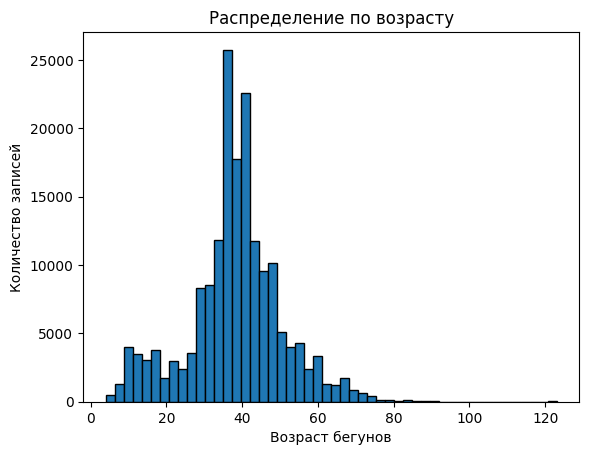

In [96]:
plt.hist(new_df['athlete_age'], bins=50, edgecolor='black')
plt.title('Распределение по возрасту')
plt.xlabel('Возраст бегунов')
plt.ylabel('Количество записей')
plt.show()

На распределении видно, что выбросами являются участники старше 80 лет

In [97]:
new_df = new_df[new_df['athlete_age'] < 80]

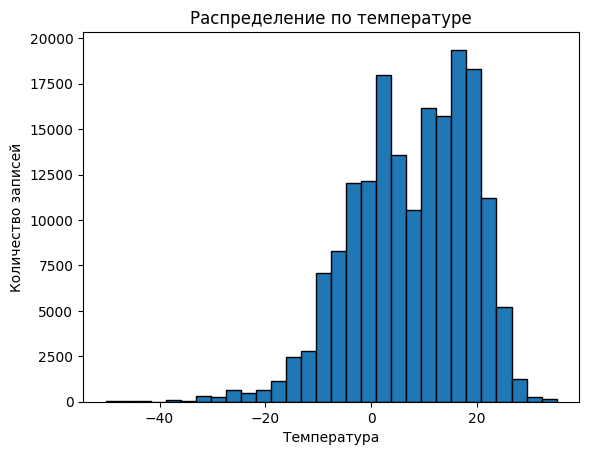

In [98]:
plt.hist(new_df['temp'], bins=30, edgecolor='black')
plt.title('Распределение по температуре')
plt.xlabel('Температура')
plt.ylabel('Количество записей')
plt.show()

In [99]:
low_temp_df = new_df[new_df['temp'] < -23]

In [100]:
low_temp_df.loc[:, 'month'] = low_temp_df['event_date'].dt.month

/var/folders/nv/y1xwhy_x1gx4gn0wks7mdjqc0000gn/T/ipykernel_60979/2967033106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_temp_df.loc[:, 'month'] = low_temp_df['event_date'].dt.month


In [101]:
low_temp_df['month'].value_counts()

month
12    825
1     804
2     112
3       9
Name: count, dtype: int64

In [102]:
low_temp_df[low_temp_df['month'] == 3]

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,...,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,month
31336,5975,790079611,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1826,женский,37,0,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
63699,5975,790104282,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1490,мужской,56,0,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74357,5975,790110203,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1486,мужской,45,0,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74460,5975,790110215,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1689,мужской,43,0,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
74533,5975,790110219,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1805,мужской,43,0,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
83487,5975,790113808,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1715,мужской,36,0,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
87402,5975,790115431,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1837,женский,47,0,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
116802,5975,790127743,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1621,мужской,24,1,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3
119581,5975,790128597,Воркута Городской парк,2023-03-04,Воркута,Республика Коми,1480,мужской,35,1,...,-29.47,97,1.38,200,Clouds,overcast clouds,NaN,NaN,асфальт,3


4-ого марта в Воркуте действительно была такая температура

In [103]:
super_low_temp_df = new_df[new_df['temp'] < -40]
super_low_temp_df['city'].unique()

array(['Якутск'], dtype=object)

В Якутске действительно очень холодно, поэтому в переменной temp нет выбросов. Тоже самое с переменной feels like

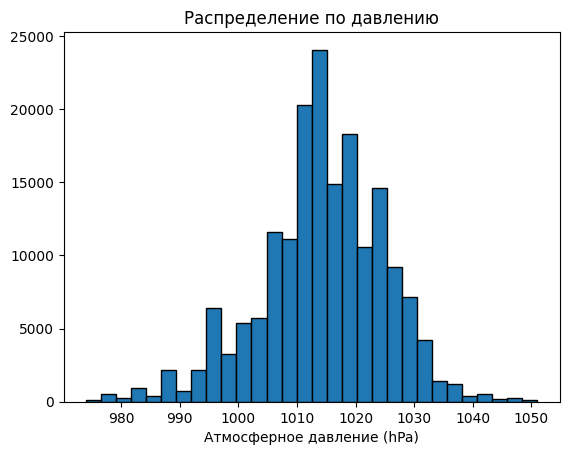

In [104]:
plt.hist(new_df['pressure'], bins=30, edgecolor='black')
plt.title('Распределение по давлению')
plt.xlabel('Атмосферное давление (hPa)')
plt.show()

В давлении нет выбросов

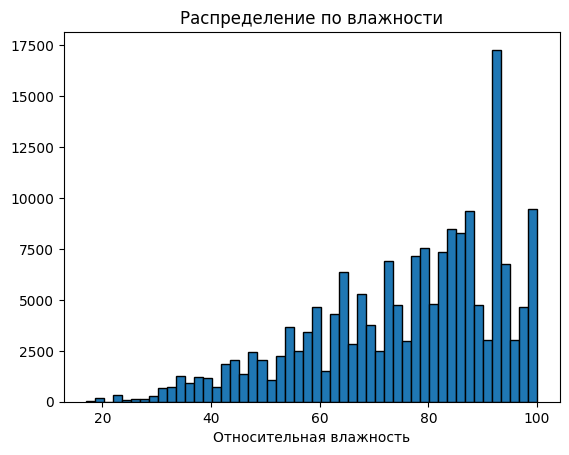

In [105]:
plt.hist(new_df['humidity'], bins=50, edgecolor='black')
plt.title('Распределение по влажности')
plt.xlabel('Относительная влажность')
plt.show()

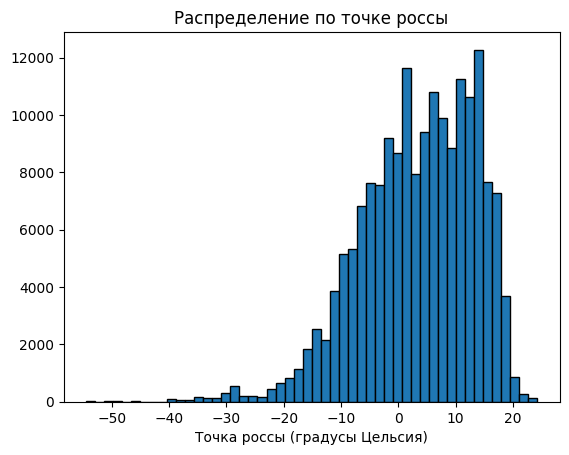

In [106]:
plt.hist(new_df['dew_point'], bins=50, edgecolor='black')
plt.title('Распределение по точке россы')
plt.xlabel('Точка россы (градусы Цельсия)')
plt.show()

In [107]:
new_df[new_df['dew_point'] < -40]['city'].value_counts()

city
Якутск         84
Новосибирск    17
Иркутск        16
Томск          15
Name: count, dtype: int64

In [108]:
super_low_point = new_df[new_df['dew_point'] < -40]
super_low_point.loc[:, 'month'] = super_low_point['event_date'].dt.month
super_low_point['month'].value_counts()

/var/folders/nv/y1xwhy_x1gx4gn0wks7mdjqc0000gn/T/ipykernel_60979/1467462739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super_low_point.loc[:, 'month'] = super_low_point['event_date'].dt.month


month
12    74
1     52
2      6
Name: count, dtype: int64

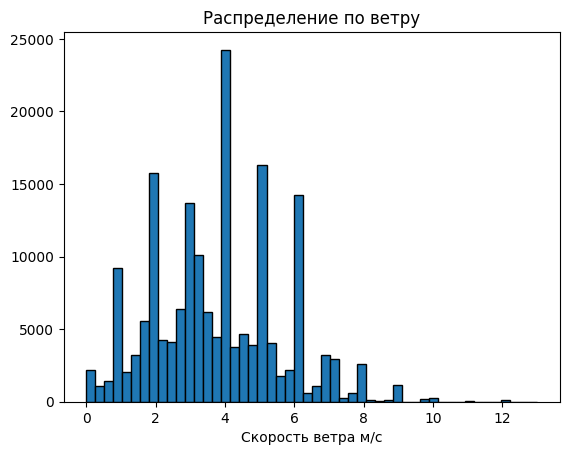

In [109]:
plt.hist(new_df['wind_speed'], bins=50, edgecolor='black')
plt.title('Распределение по ветру')
plt.xlabel('Скорость ветра м/с')
plt.show()

In [110]:
new_df['city'][new_df['wind_speed'] > 10].value_counts()

city
Екатеринбург    52
Томск           41
Челябинск       41
Кемерово        22
Омск            14
Калуга          12
Чебоксары       11
Орск            11
Железноводск     7
Name: count, dtype: int64

Вполне вероятно, что эти значенияя не выбросы, так как большинство этих городов являются ветреными

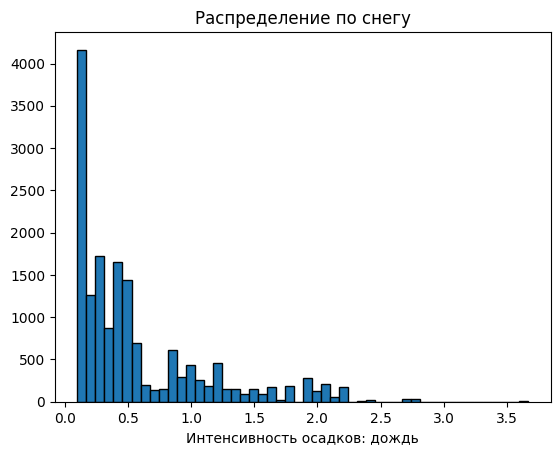

In [111]:
plt.hist(new_df['rain.1h'], bins=50, edgecolor='black')
plt.title('Распределение по снегу')
plt.xlabel('Интенсивность осадков: дождь')
plt.show()

Что-то очень странно, GPT говорит, что так распределяется:
Слабый дождь: до 2,5 мм/час.
Умеренный дождь: от 2,5 до 7,6 мм/час.
Сильный дождь: от 7,6 мм/час и выше.
Ливень: более 50 мм/час.

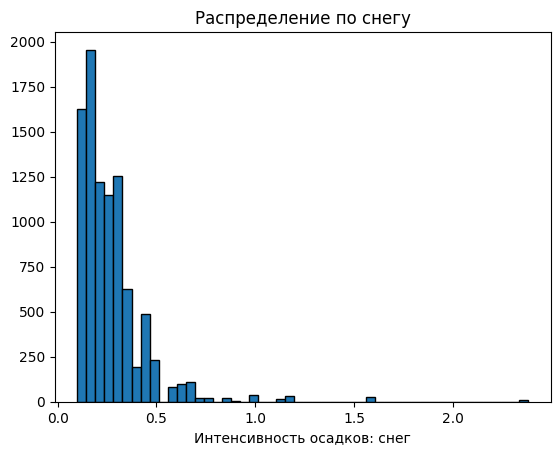

In [112]:
plt.hist(new_df['snow.1h'], bins=50, edgecolor='black')
plt.title('Распределение по снегу')
plt.xlabel('Интенсивность осадков: снег')
plt.show()

Выбросов нет